## Arquitectura de una RNN tradicional
Las redes neuronales recurrentes, también conocidas como RNN por sus siglas en inglés, son una clase de redes neuronales que permiten que salidas anteriores se utilicen como entradas, manteniendo estados ocultos. Típicamente son de la siguiente manera:
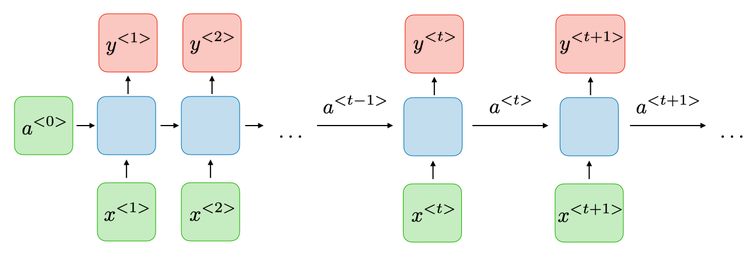

Para cada instante de tiempo 𝑡, la activación $𝑎^{⟨𝑡⟩}$ y la salida $y^{⟨t⟩}$ se expresan de la siguiente manera:
$a^{\langle t \rangle} = g_1(W_{aa} a^{\langle t-1 \rangle} + W_{ax} x^{\langle t \rangle} + b_a)
\quad \text{y} \quad
y^{\langle t \rangle} = g_2(W_{ya} a^{\langle t \rangle} + b_y)$

Donde $W_{ax}, W_{aa}, W_{ya}, b_a, b_y$ son coeficientes que son compartidos temporalmente y $g_1, g_2$ son funciones de activación

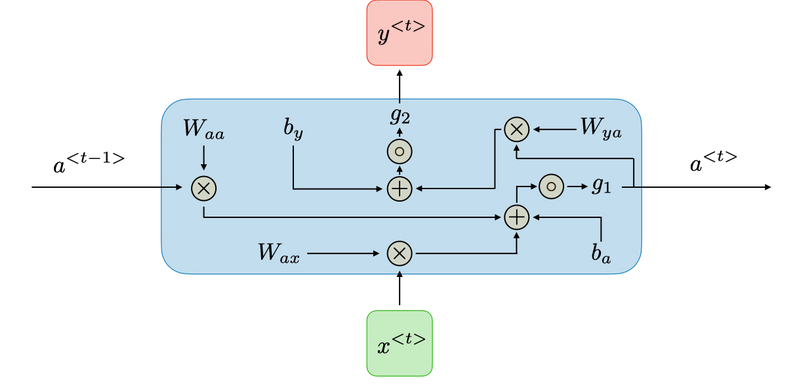

| **Ventajas**                                                                 | **Desventajas**                                                                 |
|------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| • Posibilidad de procesar entradas de cualquier longitud                    | • El cómputo puede ser lento                                                    |
| • El tamaño del modelo no crece con el tamaño de la entrada                 | • Dificultad para acceder a información de hace mucho tiempo                   |
| • El cómputo toma en cuenta la información histórica                        | • No puede considerar entradas futuras para el estado actual                   |
| • Los pesos se comparten a lo largo del tiempo                              |                                                                                  |


## Aplicaciones de las RNN
Los modelos RNN se utilizan principalmente en los campos del procesamiento del lenguaje natural y el reconocimiento de voz. Las diferentes aplicaciones se resumen en la siguiente tabla:

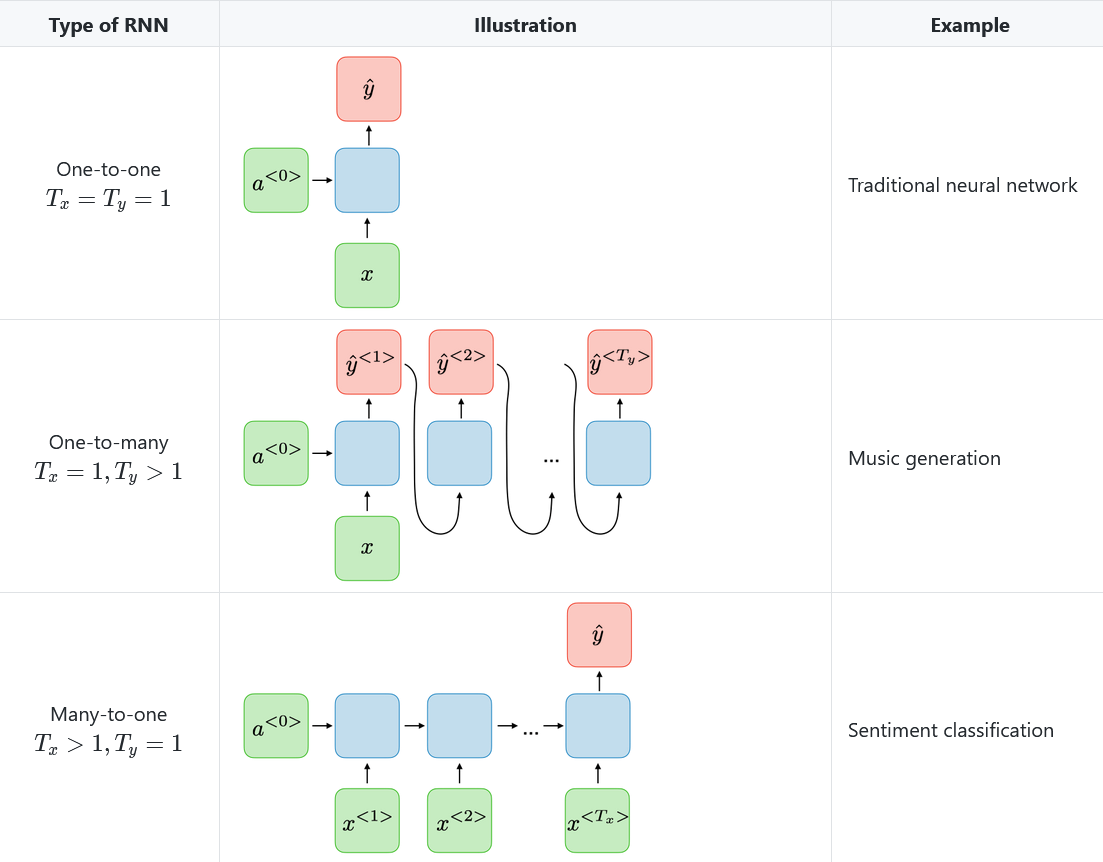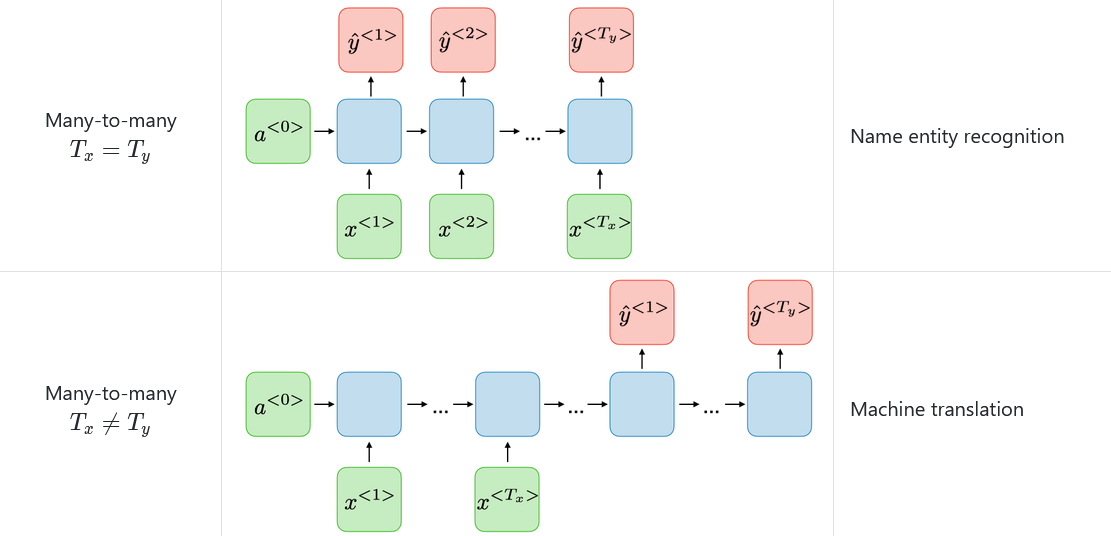

##Función de pérdida
En el caso de una red neuronal recurrente, la función de pérdida
𝐿
 de todos los pasos de tiempo se define en base a la pérdida en cada paso de tiempo de la siguiente manera:

 $\begin{align*}\mathcal{L}(\widehat{y},y)=\sum_{t=1}^{T_y} \mathcal{L}(\widehat{y}^{<t>},y^{<t>})\end{align*}$

## Retropropagación a través del tiempo
La retropropagación se realiza en cada instante de tiempo. En el paso de tiempo
𝑇 , la derivada de la pérdida
𝐿  con respecto a la matriz de pesos
𝑊
 se expresa de la siguiente manera:

 $\frac{\partial \mathcal{L}^{(T)}}{\partial W} = \sum_{t=1}^{T} \left. \frac{\partial \mathcal{L}^{(T)}}{\partial W} \right|_{(t)}$

## Desvanecimiento/explotación del gradiente
Los fenómenos de gradiente que desaparece y gradiente que explota se encuentran con frecuencia en el contexto de las RNN. La razón por la que ocurren es que es difícil capturar dependencias a largo plazo debido a que el gradiente multiplicativo puede disminuir o aumentar exponencialmente con respecto al número de capas.

## Recorte de gradiente
Es una técnica utilizada para hacer frente al problema del gradiente que explota, que a veces ocurre durante la retropropagación. Al limitar el valor máximo del gradiente, este fenómeno se controla en la práctica.

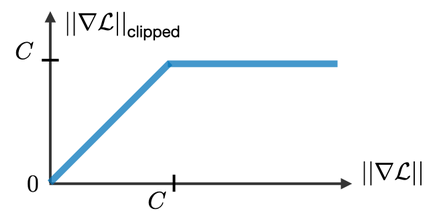


## Tipos de compuertas
Para remediar el problema del gradiente que desaparece, se utilizan compuertas específicas en algunos tipos de RNN, las cuales suelen tener un propósito bien definido. Generalmente se denotan como
Γ y son iguales a:


$\begin{align*}\Gamma = \sigma (W x^{<t>} + U a^{<t-1>} + b)\end{align*}$

donde $W, U, b$ son coeficientes específicos de la compuerta y $\sigma$ es la función sigmoide. Las principales compuertas se resumen en la siguiente tabla:

| Tipo de compuerta            | Función                              | Usada en    |
|------------------------------|--------------------------------------|-------------|
| Compuerta de actualización (Γᵤ) | ¿Cuánto debe importar el pasado ahora? | GRU, LSTM   |
| Compuerta de relevancia ($Γᵣ$)    | ¿Descartar información previa?        | GRU, LSTM   |
| Compuerta de olvido ($Γ_f$)       | ¿Borrar una celda o no?               | LSTM        |
| Compuerta de salida (Γₒ)        | ¿Cuánto revelar de una celda?         | LSTM        |

## Unidad Recurrente con Puertas (GRU) y Memoria a Largo y Corto Plazo (LSTM)

Las unidades Gated Recurrent Unit (GRU) y Long Short-Term Memory (LSTM) abordan el problema del gradiente desvanecido que presentan las RNN tradicionales, siendo la LSTM una generalización de la GRU. A continuación, se muestra una tabla que resume las ecuaciones características de cada arquitectura:

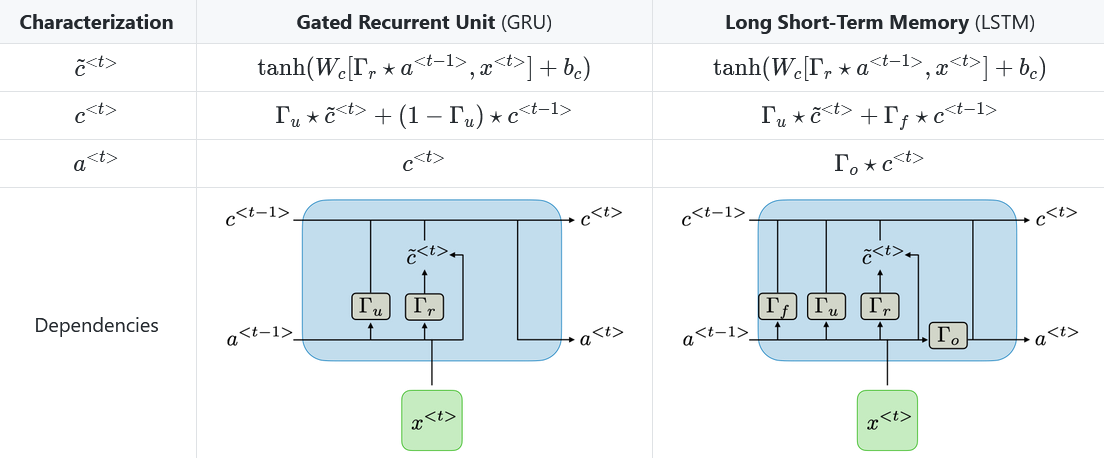

## Variantes de las RNN

La siguiente tabla resume otras arquitecturas de RNN comúnmente utilizadas:

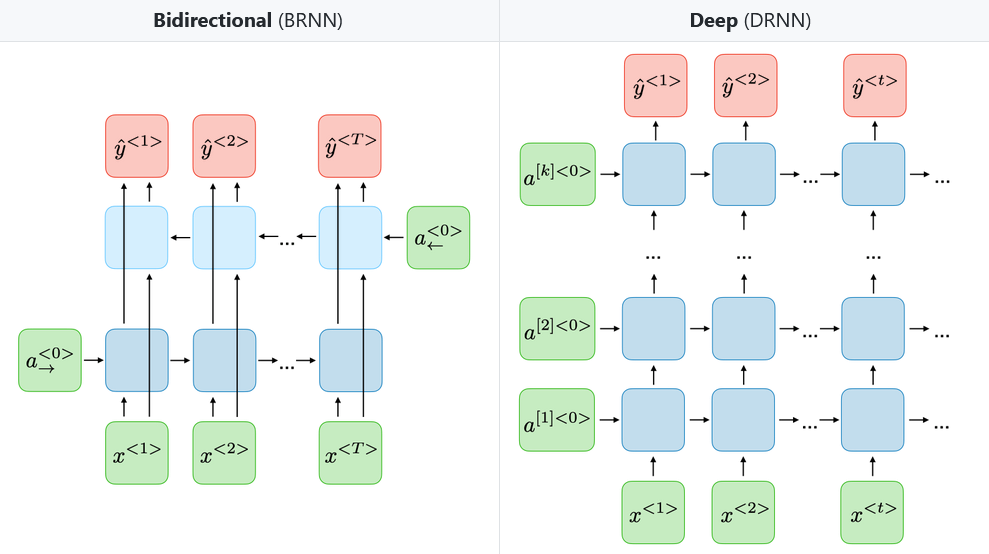

# RNN con JAX

In [58]:
import os

# This guide can only be run with the jax backend.
os.environ["KERAS_BACKEND"] = "jax"

import jax

# We import TF so we can use tf.data.
import tensorflow as tf
import keras
import numpy as np

In [59]:


import tensorflow_datasets as tfds
#!pip install tensorflow-text
!import tensorflow_text as tf_text
from datetime import datetime
#!pip install tensorflow_datasets

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Embedding,Dense
from tensorflow.keras import Sequential,layers
from keras.layers import LSTM
from tensorflow.keras import losses
import pandas as pd
print(tf.__version__)



/bin/bash: line 1: import: command not found
2.18.0


In [60]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:20%]', 'train[22%:24%]', 'test[:20%]'),
    as_supervised=True)

In [61]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(1)))
print(train_examples_batch,train_labels_batch)

tf.Tensor([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."], shape=(1,), dtype=string) tf.Tensor([0], shape=(1,), dtype=int64)


In [62]:
def data_load_txt(data_ds,shuffle_=True ,batch_=12):
    data_ds = data_ds.cache()
    if shuffle_:
        data_ds = data_ds.shuffle(len(data_ds))
    data_ds = data_ds.batch(batch_)
    data_ds = data_ds.prefetch(tf.data.AUTOTUNE)
    return data_ds

In [63]:
BATCH=128
data_train = data_load_txt(train_data,batch_=BATCH)
data_test = data_load_txt(test_data,shuffle_=False,batch_=BATCH)
data_val = data_load_txt(validation_data,shuffle_=False,batch_=BATCH)

In [64]:
for ds,lb in data_train.take(1):
    shaped=ds.shape

In [65]:
def tf_lower_and_split_punct(text):

  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [66]:
max_vocab_size = 10000

input_text_processor = layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=100,  # longitud fija para que LSTM reciba secuencia fija
)

In [67]:
reviews_only_ds = data_train.map(lambda a, b: a)
input_text_processor.adapt(reviews_only_ds)

In [68]:
input_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('the'),
 np.str_('.'),
 np.str_(','),
 np.str_('and'),
 np.str_('a'),
 np.str_('of'),
 np.str_('to'),
 np.str_('is')]

In [69]:
for idx in data_train.take(3):
    example_tokens = input_text_processor(idx[0])
    print(idx[1], example_tokens)

tf.Tensor(
[1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1
 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0
 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0
 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1], shape=(128,), dtype=int64) [[  33   13 1450 ...  220    4    2]
 [  33    2  120 ... 1048    5 5447]
 [  33   13   16 ...    0    0    0]
 ...
 [  33 2794   27 ...  118   18  261]
 [  33 5085    9 ... 5476    8 1364]
 [  33   60 3782 ...   72  169  119]]
tf.Tensor(
[1 1 0 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 0 0 1 1 0 1 0 0 0
 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 1 1
 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1], shape=(128,), dtype=int64) [[  33 1229    7 ...    0    0    0]
 [  33   13  118 ... 7996    1    5]
 [  33  149  168 ...   67  522 1139]
 ...
 [  33    6   28 ...    3  444 1555]
 [  33   42  114 ..

In [70]:
example_tokens

Array([[  33,    1,   17, ...,  389,    2,  295],
       [  33,   14,   16, ...,  785, 1178,    3],
       [  33,   13,  190, ...,    0,    0,    0],
       ...,
       [  33,   13,  254, ...,  279,    5,  163],
       [  33,   47,  287, ...,    5, 2372,    2],
       [  33, 2564,   41, ...,   10,   10,   14]], dtype=int32)

In [71]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[np.array(example_tokens[2])]
' '.join(tokens)

'[START] i may not be a critic , but here is what i think of this movie . well just watched the movie on [UNK] and first of all i just have to say how much i hate the storyline i mean come on what does a snowman scare besides little kids , secondly it is pretty gory but i bet since the movie is so low budget they probably used [UNK] so my critical vote is bomb ! ! ! nice try and the sequel will suck twice as much . [END]       '

Text(0.5, 1.0, 'Mask')

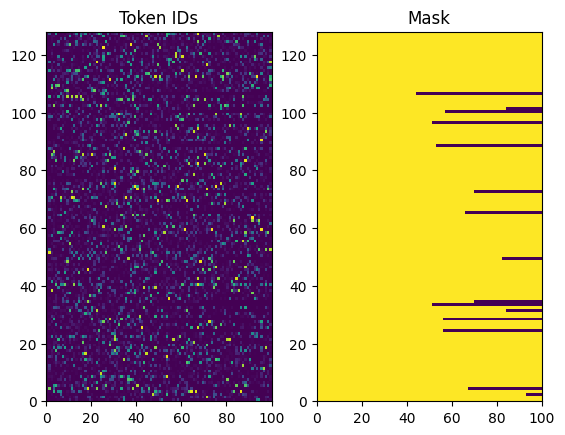

In [72]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [73]:
# Parámetros
max_vocab_size = 10000
embedding_dim = 64
batch_size = 32

# Definimos el preprocesador (text vectorization)
def tf_lower_and_split_punct(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, r"[^\w\s]", " ")
    return text

# Preparamos el vocabulario con el dataset completo de entrenamiento
text_ds = train_data.map(lambda text, label: text)
input_text_processor.adapt(text_ds.batch(128))

In [74]:
# Modelo Keras usando la arquitectura dada
# La entrada al modelo debe ser directamente los IDs numéricos ahora
inputs = layers.Input(shape=(100,), dtype=tf.int64) # Shape matches output_sequence_length
# Removed input_preproc as text processing is done outside the model for JAX
embedding = layers.Embedding(input_dim=max_vocab_size + 1, output_dim=embedding_dim, name="embedding")(inputs)
lstm = layers.LSTM(32, return_sequences=True)(embedding)
lstm_stage = layers.LSTM(32)(lstm)
output = layers.Dense(1)(lstm_stage)
model = tf.keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 64)        │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 100, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 660,833 (2.52 MB)

 Trainable params: 660,833 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Configuramos optimizador y función pérdida
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)  # salida es un solo logit

In [76]:
# Métricas
train_acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()

In [77]:
# Agrupa los datos en lotes del tamaño batch_size.

train_dataset = train_data.batch(batch_size).map(lambda x, y: (input_text_processor(x), y)).prefetch(1)

val_dataset = validation_data.batch(batch_size).map(lambda x, y: (input_text_processor(x), y)).prefetch(1)

In [78]:
import jax
import jax.numpy as jnp
import numpy as np

def fit(model,
              optimizer,
              loss_fn,
              train_metric,
              val_metric,
              train_dataset,   # ya batcheado externamente
              val_dataset,     # ya batcheado externamente
              num_epochs):
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    # Inicializa estado
    optimizer.build(model.trainable_variables)
    tv   = model.trainable_variables
    ntv  = model.non_trainable_variables
    opt_v = optimizer.variables
    mv   = train_metric.variables
    state = (tv, ntv, opt_v, mv)

    # Definición de train_step y eval_step
    def compute_loss_and_updates(tv, ntv, mv, x, y):
        y_pred, ntv = model.stateless_call(tv, ntv, x, training=True)
        loss = loss_fn(y, y_pred)
        mv   = train_metric.stateless_update_state(mv, y, y_pred)
        return loss, (ntv, mv)

    grad_fn = jax.value_and_grad(compute_loss_and_updates, has_aux=True)

    @jax.jit
    def train_step(state, batch):
        tv, ntv, opt_v, mv = state
        x, y = batch
        (loss, (ntv, mv)), grads = grad_fn(tv, ntv, mv, x, y)
        tv, opt_v = optimizer.stateless_apply(opt_v, grads, tv)
        return loss, (tv, ntv, opt_v, mv)

    @jax.jit
    def eval_step(state, batch):
        tv, ntv, mv = state
        x, y = batch
        y_pred, ntv = model.stateless_call(tv, ntv, x, training=False)
        loss = loss_fn(y, y_pred)
        mv   = val_metric.stateless_update_state(mv, y, y_pred)
        return loss, (tv, ntv, mv)

    # Bucle de entrenamiento por épocas
    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")
        train_metric.reset_state()
        val_metric.reset_state()

        # — Training —
        for step, (x_batch, y_batch) in enumerate(train_dataset, start=1):
            x_j = jnp.array(x_batch.numpy())
            y_j = jnp.array(y_batch.numpy())
            loss, state = train_step(state, (x_j, y_j))

            # Logging cada 100 batches
            if step % 100 == 0:
                _, _, _, mv = state
                for var, val in zip(train_metric.variables, mv):
                    var.assign(val)
                acc = float(train_metric.result())
                seen = step * batch_size
                print(f"  [Train] batch {step}, samples seen {seen}, loss {loss:.4f}, acc {acc:.4f}")

        # Guardar métricas al final de la época
        history['loss'].append(float(loss))
        history['accuracy'].append(float(train_metric.result()))

        # — Validation —
        tv, ntv, opt_v, _ = state
        val_state = (tv, ntv, val_metric.variables)
        for step, (x_batch, y_batch) in enumerate(val_dataset, start=1):
            x_j = jnp.array(x_batch.numpy())
            y_j = jnp.array(y_batch.numpy())
            val_loss, val_state = eval_step(val_state, (x_j, y_j))

            if step % 100 == 0:
                _, _, mv = val_state
                for var, val in zip(val_metric.variables, mv):
                    var.assign(val)
                acc = float(val_metric.result())
                seen = step * batch_size
                print(f"  [Val]   batch {step}, samples seen {seen}, loss {val_loss:.4f}, acc {acc:.4f}")

        history['val_loss'].append(float(val_loss))
        history['val_accuracy'].append(float(val_metric.result()))

        print(f"→ End epoch {epoch}: train_loss={history['loss'][-1]:.4f}, "
              f"train_acc={history['accuracy'][-1]:.4f}, "
              f"val_loss={history['val_loss'][-1]:.4f}, "
              f"val_acc={history['val_accuracy'][-1]:.4f}")

    return history


In [79]:
history = fit(
    model=model,
    optimizer=keras.optimizers.Adam(1e-3),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    train_metric=keras.metrics.BinaryAccuracy(),
    val_metric=keras.metrics.BinaryAccuracy(),
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=4
)


Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/backend/jax/core.py:77: UserWarning: Explicitly requested dtype int64 requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.asarray(x, dtype=dtype)


  [Train] batch 100, samples seen 3200, loss 0.5411, acc 0.5450
→ End epoch 1: train_loss=1.2451, train_acc=0.5450, val_loss=0.4440, val_acc=0.0000

Epoch 2/4
  [Train] batch 100, samples seen 3200, loss 0.4226, acc 0.6902
→ End epoch 2: train_loss=1.1573, train_acc=0.6902, val_loss=0.3028, val_acc=0.0000

Epoch 3/4
  [Train] batch 100, samples seen 3200, loss 0.4269, acc 0.7702
→ End epoch 3: train_loss=0.1302, train_acc=0.7702, val_loss=0.5304, val_acc=0.0000

Epoch 4/4
  [Train] batch 100, samples seen 3200, loss 0.4627, acc 0.8184
→ End epoch 4: train_loss=0.0337, train_acc=0.8184, val_loss=0.8113, val_acc=0.0000


In [80]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = input_text_processor.get_vocabulary()

In [81]:
weights.shape

(10001, 64)

In [82]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [83]:
import os
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), './aclImdb_v1/aclImdb')

In [84]:
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'train', 'README']

In [85]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['pos',
 'unsup',
 'neg',
 'labeledBow.feat',
 'urls_neg.txt',
 'unsupBow.feat',
 'urls_pos.txt',
 'urls_unsup.txt']

In [86]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [87]:
import shutil
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [88]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['pos',
 'neg',
 'labeledBow.feat',
 'urls_neg.txt',
 'unsupBow.feat',
 'urls_pos.txt',
 'urls_unsup.txt']

In [89]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb_v1/aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb_v1/aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb_v1/aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [90]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [91]:
import re
import string

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [92]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [93]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [94]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [95]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [96]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [97]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [98]:
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [99]:
# Supongamos que train_dataset está listo y hace .map(input_text_processor)
x0, _ = next(iter(train_dataset))    # toma el primer lote (batch_size, 100)
model(x0)                            # crea los pesos internamente


Array([[ 0.00606806],
       [-0.00716638],
       [-0.00626018],
       [-0.00190015],
       [-0.00558802],
       [-0.00576673],
       [-0.00258906],
       [-0.00655908],
       [-0.00890126],
       [-0.00575366],
       [-0.0082507 ],
       [-0.00766707],
       [-0.00882859],
       [ 0.00421966],
       [-0.01601707],
       [ 0.00388472],
       [-0.01020652],
       [-0.00329695],
       [-0.00528682],
       [-0.00651656],
       [-0.01046867],
       [-0.00853674],
       [-0.00410091],
       [-0.00732167],
       [-0.00355641],
       [-0.01468264],
       [-0.00321334],
       [-0.00656558],
       [ 0.00234178],
       [-0.00902095],
       [-0.00654486],
       [-0.01124274]], dtype=float32)

In [100]:
history = fit(
    model=model,
    optimizer=keras.optimizers.Adam(1e-3),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    train_metric=keras.metrics.BinaryAccuracy(),
    val_metric=keras.metrics.BinaryAccuracy(),
    train_dataset=train_ds,
    val_dataset=val_ds,
    num_epochs=2
)


Epoch 1/2
  [Train] batch 100, samples seen 3200, loss 0.6923, acc 0.5144
  [Train] batch 200, samples seen 6400, loss 0.6867, acc 0.4998
  [Train] batch 300, samples seen 9600, loss 0.6636, acc 0.5032
  [Train] batch 400, samples seen 12800, loss 0.6670, acc 0.5049
  [Train] batch 500, samples seen 16000, loss 0.6516, acc 0.5019
  [Train] batch 600, samples seen 19200, loss 0.6291, acc 0.5063
  [Val]   batch 100, samples seen 3200, loss 0.6024, acc 0.5309
→ End epoch 1: train_loss=0.6162, train_acc=0.5063, val_loss=0.5898, val_acc=0.5309

Epoch 2/2
  [Train] batch 100, samples seen 3200, loss 0.5639, acc 0.5159
  [Train] batch 200, samples seen 6400, loss 0.5841, acc 0.5282
  [Train] batch 300, samples seen 9600, loss 0.5652, acc 0.5417
  [Train] batch 400, samples seen 12800, loss 0.4973, acc 0.5539
  [Train] batch 500, samples seen 16000, loss 0.4560, acc 0.5678
  [Train] batch 600, samples seen 19200, loss 0.4825, acc 0.5818
  [Val]   batch 100, samples seen 3200, loss 0.5295, acc

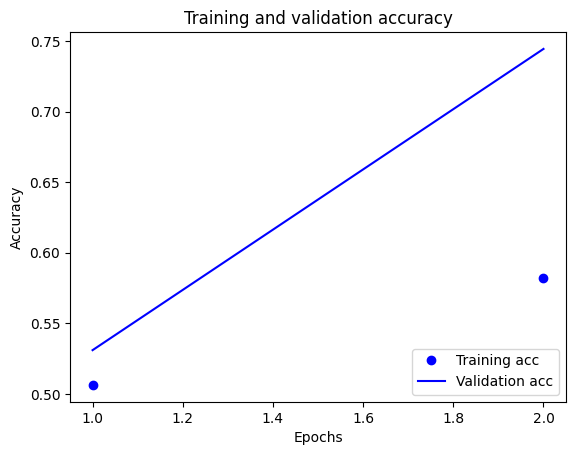

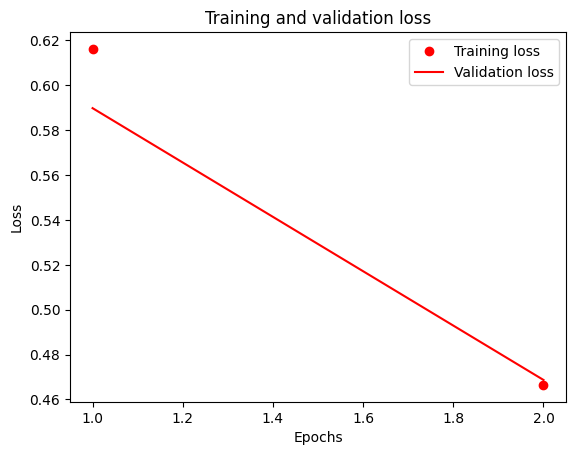

In [101]:
import matplotlib.pyplot as plt

# Si `history` es el dict devuelto por run_training_loop_by_epochs:
history_dict = history

# Extraemos series
acc     = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss    = history_dict['loss']
val_loss= history_dict['val_loss']

# Rango de épocas (1, 2, …, N)
epochs = range(1, len(acc) + 1)

# — Gráfica de exactitud —
plt.figure()
plt.plot(epochs, acc,     'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b' , label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# — Gráfica de pérdida —
plt.figure()
plt.plot(epochs, loss,     'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r' , label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()
